In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay
import sklearn.gaussian_process.kernels as k
from scipy.interpolate import interp1d
from tqdm import tqdm
from astroML.utils import split_samples
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
pip install pyarrow

Note: you may need to restart the kernel to use updated packages.


In [3]:
def plot_timeseries(df: pd.DataFrame, indx=0 ) -> None:
    '''Plot the generated time series data.
        Args:
            df: Pandas DataFrame with the generated data
            indx: index of the time series to plot
        '''
    df[f'y{indx}' ].plot(style='o')  

    plt.show()

In [4]:
def plottingFits(x, y, x_pred, y_pred, x_model, y_model, sigma, fit_unc):
    plt.figure(figsize=(10, 5))
    plt.scatter(x, y, label='Data')
    plt.plot(x_model, y_model, c='r')
    #plt.plot(x_pred, y_pred, 'b-', label='Prediction with GP')
    plt.fill_between(
        x_model,
        y_model - (1.96 * fit_unc),
        y_model + (1.96 * fit_unc),
        alpha=0.3,
        label="95% confidence interval(GP)"
    )
    plt.xlabel('$x$')
    plt.ylabel('$f(x)$')
    plt.legend()
    return(plt.show())

In [5]:
def data_read_test(data_type):

        if (data_type == 'single'):
            df = pd.read_feather("Project data/timeseries_single_frequency.feather")
        
        tSeries = df.index.values
        intensity_data = df.values
    
        return(tSeries, intensity_data)

In [6]:
def data_read(data_type, image_number = 20):
    
    if (data_type == 'plasticc'):
        
        plasticc_metadata = pd.read_pickle('Project data/plasticc_lightcurves_g_metadata.pkl')
        with open('Project data/plasticc_lightcurves_g.pkl', 'rb') as file:
            plasticc_LC = pickle.load(file)

        tSeries = plasticc_LC[plasticc_metadata['object_id'].iloc[image_number]].index.values
        intensity_data = plasticc_LC[plasticc_metadata['object_id'].iloc[image_number]].values
        y_true = plasticc_metadata['true_target'].iloc[image_number]
        return(np.array(tSeries), intensity_data, y_true)
    
    if(data_type == 'plasticc_test'):
        lcs = []
        plasticc_metadata = pd.read_pickle('Project data/plasticc_lightcurves_g_metadata.pkl')
        with open('Project data/plasticc_lightcurves_g.pkl', 'rb') as file:
            plasticc_LC = pickle.load(file)
            
        y_true = plasticc_metadata['target'].iloc[:].values

        for i in tqdm(range(len(plasticc_metadata))):
            try:
                lc = (np.array([(plasticc_LC[plasticc_metadata['object_id'].iloc[i]].index).values, plasticc_LC[plasticc_metadata['object_id'].iloc[i]].values]).T).tolist()
                lcs.append(lc)
            except KeyError:
                continue
        return(lcs, y_true)
    
    else:
        if (data_type == 'single'):
            df = pd.read_feather("Project data/timeseries_single_frequency.feather")

        elif (data_type == 'multiple'):
            df = pd.read_feather("Project data/timeseries_multiple_frequency.feather")

        elif (data_type == 'multiple_sampled'):
            df = pd.read_feather("Project data/timeseries_multiple_frequency_sampled.feather")
    
        tSeries = df['y50']
        time_range = tSeries.axes[0].tolist()
        intensity_data = tSeries.values
    
        return(np.array(time_range), intensity_data)

In [7]:
def pointPrediction(new_fit, n_pred, x, y):
    delta_t = x[-1] - x[-2]
    x_pred = (np.array([range(1, 1 + n_pred)]).T)*delta_t + x[-1]
    
    return(x_pred, *new_fit.predict(x_pred, return_std = True))

In [8]:
def gaussianProcess_fitting(x, y, kernel, n_pred):
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=90)
    gp.fit(x, y)
    optimizedParams = gp.kernel_
    
    x_pred, y_pred, sigma = pointPrediction(gp, n_pred, x, y)
    
    #x_model = np.concatenate([x, x_pred])
    x_model = np.linspace(min(x), max(x_pred), 100)
    y_model, fit_unc = gp.predict(x_model, return_std=True)
    
    return(x_pred, y_pred, sigma, optimizedParams, x_model, y_model, fit_unc)

/opt/conda/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Optimized hyper parameters:  6.37**2 * RBF(length_scale=22.1)


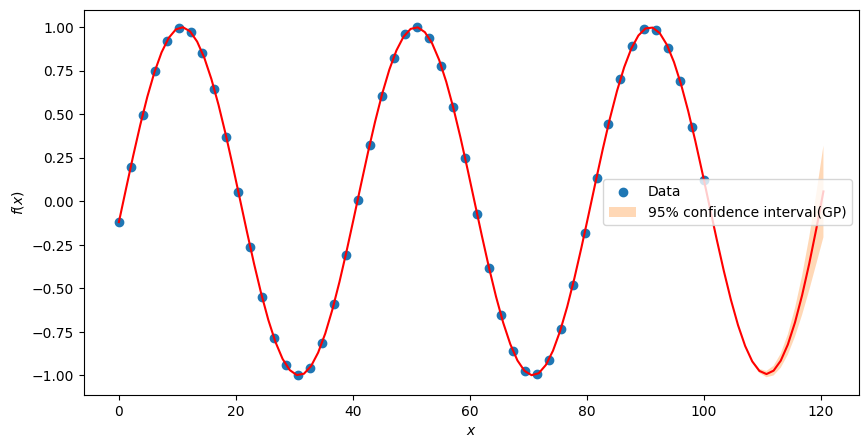

In [168]:
x, y = data_read('single')
x_true = x
x = x.reshape(-1,1)
n_points = 10

kernel = np.var(y) * k.RBF(length_scale=10.0)


x_pred, y_pred, sigma, optimizedParameters, x_model, y_model, fit_unc = gaussianProcess_fitting(x, y, kernel, n_pred = n_points)
print("Optimized hyper parameters: ", optimizedParameters)


plottingFits(x, y, x_pred, y_pred, x_model.flatten(), y_model.flatten(), sigma, fit_unc)

In [75]:
def RNN_fitting_single_test(x, y):
    
    (X_train, X_valid, X_test), (y_train, y_valid, y_test) = split_samples(x, y, [0.8, 0.1, 0.1], random_state=0)
    
    model = keras.Sequential([
    layers.Input(np.shape(X_train[0].reshape(-1, 1))),
    layers.GRU(32, return_sequences=True),
    layers.GRU(14),
    layers.Dense(10, activation='linear')
    ])

    model.summary()

    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
        loss=keras.losses.MeanSquaredError(),
        metrics=[keras.metrics.RootMeanSquaredError()]
    )

    callbacks = [
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.1,
            patience=5,
            verbose=1,
            min_delta=1e-4,
        ),
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            min_delta=1e-4,
            patience=10,
            verbose=1,
        )
    ]

    history = model.fit(X_train,
        y_train,
        batch_size=128,
        epochs=100,
        validation_data=(X_valid, y_valid),
        callbacks=callbacks
    )

    pred_proba = model.predict(X_test)
    return(X_test, pred_proba, y_test)

In [76]:
x, y = data_read_test('single')

y_test = y[:-10,:].T[0:2000]
y_fit = y[-10:,:].T[0:2000]

RNN_X, RNN_Y, y_test = RNN_fitting_single_test(y_test, y_fit)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_24 (GRU)                (None, 40, 32)            3360      
                                                                 
 gru_25 (GRU)                (None, 14)                2016      
                                                                 
 dense_10 (Dense)            (None, 10)                150       
                                                                 
Total params: 5,526
Trainable params: 5,526
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
13/13 [==============================] - 4s 150ms/step - loss: 0.4190 - root_mean_squared_error: 0.6473 - val_loss: 0.3295 - val_root_mean_squared_error: 0.5740 - lr: 0.0010
Epoch 2/100
13/13 [==============================] - 1s 45ms/step - loss: 0.2892 - root_mean_squared_error: 0.5378 - val_loss: 0.

In [81]:
test = 100
print(RNN_X[test])
print(RNN_Y[test])

[ 0.14248541 -0.17666654 -0.4778182  -0.73028568 -0.90834544 -0.99385524
 -0.97810262 -0.86269258 -0.65938408 -0.38889193 -0.07877615  0.239366
  0.53311952  0.77255428  0.93327464  0.99890504  0.9627585   0.82851794
  0.60986092  0.32906608  0.01474319 -0.30108186 -0.58623013 -0.81164829
 -0.95436881 -0.99985013 -0.94345821 -0.79093874 -0.5578317  -0.26788803
  0.04935036  0.36156051  0.6369318   0.84740706  0.97154128  0.99668661
  0.92028104  0.7501094   0.50351023  0.20560917]
[-0.12408216 -0.38794994 -0.6539705  -0.88717544 -0.98420775 -0.992393
 -0.87912816 -0.68983227 -0.4454728  -0.13969576]


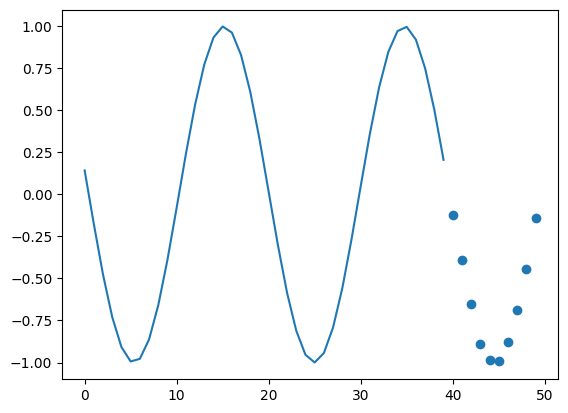

In [82]:
plt.plot(RNN_X[test])
plt.scatter(range(40,50), RNN_Y[test])

/opt/conda/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Optimized hyper parameters:  4.73**2 * RBF(length_scale=40.6)


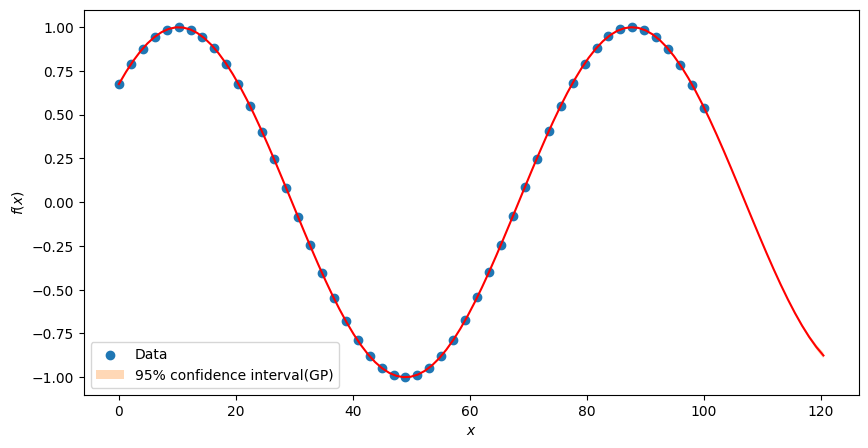

In [9]:
x, y = data_read('multiple')
x_true = x
x = x.reshape(-1,1)

n_points = 10

kernel = np.var(y) * k.RBF(length_scale=10.0)


x_pred, y_pred, sigma, optimizedParameters, x_model, y_model, fit_unc = gaussianProcess_fitting(x, y, kernel, n_pred = n_points)
print("Optimized hyper parameters: ", optimizedParameters)


plottingFits(x, y, x_pred, y_pred, x_model.flatten(), y_model.flatten(), sigma, fit_unc)

/opt/conda/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Optimized hyper parameters:  4.59**2 * RBF(length_scale=40.1)


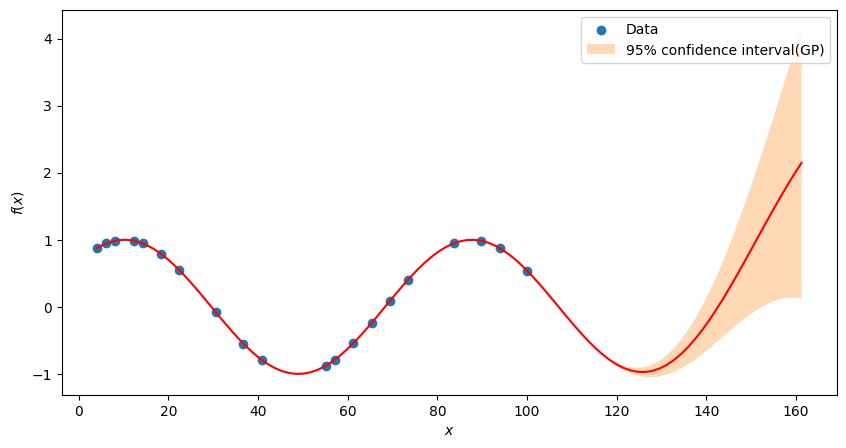

In [10]:
x, y = data_read('multiple_sampled')
x_true = x
x = x.reshape(-1,1)
x = x[~np.isnan(y)]
y = y[~np.isnan(y)]
n_points = 10

kernel = np.var(y) * k.RBF(length_scale=10.0)


x_pred, y_pred, sigma, optimizedParameters, x_model, y_model, fit_unc = gaussianProcess_fitting(x, y, kernel, n_pred = n_points)
print("Optimized hyper parameters: ", optimizedParameters)


plottingFits(x, y, x_pred, y_pred, x_model.flatten(), y_model.flatten(), sigma, fit_unc.flatten())

Optimized hyper parameters:  68.5**2 * RBF(length_scale=11.6)


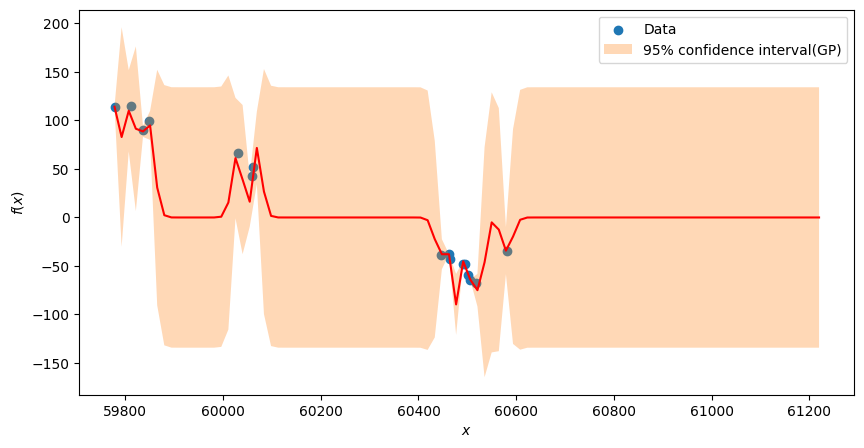

88


In [26]:
x, y, type_true = data_read('plasticc', image_number = 1000)
x_true = x
x = x.reshape(-1,1)
x = x[~np.isnan(y)]
y = y[~np.isnan(y)]
n_points = 10

kernel = np.var(y) * k.RBF(length_scale=10.0)


x_pred, y_pred, sigma, optimizedParameters, x_model, y_model, fit_unc = gaussianProcess_fitting(x, y, kernel, n_pred = n_points)
print("Optimized hyper parameters: ", optimizedParameters)


plottingFits(x, y, x_pred, y_pred, x_model.flatten(), y_model.flatten(), sigma, fit_unc)
print(type_true)

In [45]:
def RNN_fitting(lcs, y, n_pred):
     
    y_cat = (lcs[:,0][:][:, -10:])
    lc_x = lcs[:,0][:][:, :-10]
    print(np.shape(y_cat))
    print(np.shape(lc_x))
    
    (X_train, X_valid, X_test), (y_train, y_valid, y_test) = split_samples(lc_x, y_cat, [0.8, 0.1, 0.1], random_state=0)

                 
    model = keras.Sequential([
    layers.Input(np.shape(X_train[0].reshape(-1,1))),
    layers.GRU(32, return_sequences=True),
    layers.GRU(16, return_sequences=True),
    layers.GRU(16, return_sequences=True),
    layers.GRU(14),
    layers.Dense(10, activation='silu')
    ])

    model.summary()
    '''
    model.compile(
        # Optimizer
        optimizer=keras.optimizers.Adam(learning_rate=1e-2),
        # Loss function to minimize
        loss=keras.losses.CategoricalCrossentropy(),
        # List of metrics to monitor
        metrics=[keras.metrics.CategoricalAccuracy()],
    )'''
    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
        loss=keras.losses.MeanSquaredError(),
        metrics=[keras.metrics.RootMeanSquaredError()]
    )

    callbacks = [
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.1,
            patience=5,
            verbose=1,
            min_delta=1e-4,
        ),
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            min_delta=1e-4,
            patience=10,
            verbose=1,
        )
    ]

    history = model.fit(X_train,
        y_train,
        batch_size=128,
        epochs=100,
        validation_data=(X_valid, y_valid),
        callbacks=callbacks
    )

    pred_proba = model.predict(X_test)
    return(X_test, pred_proba, y_test)
    #pred_class = np.argmax(pred_proba, axis=1)
    #plt.scatter(*pred_proba)
    #plottingFits(x, y, x_pred, y_pred, x_model.flatten(), y_model.flatten(), sigma, fit_unc.flatten())
    '''
    fig = plt.figure(figsize=(17,4))
    ax = plt.subplot(1,3,1)
    #ConfusionMatrixDisplay.from_predictions(np.argmax(y_test, axis=1), pred_class, cmap='Blues', ax=ax, xticks_rotation=45)
    plt.title('counts')
    ax = plt.subplot(1,3,2)
    #ConfusionMatrixDisplay.from_predictions(np.argmax(y_test, axis=1), pred_class, cmap='Blues', ax=ax, normalize='true', values_format='.3f',  xticks_rotation=45)
    plt.title('normalized by true label')
    ax = plt.subplot(1,3,3)
    #ConfusionMatrixDisplay.from_predictions(np.argmax(y_test, axis=1), pred_class, cmap='Blues', ax=ax, normalize='pred', values_format='.3f', xticks_rotation=45)
    plt.title('normalized by prediction')
    plt.show()'''
    #return(plt.show)

In [46]:
def lf_processing(lcs):
    time_sample = np.zeros((len(lcs), 50))
    lc_sample = np.zeros((len(lcs), 50))

    for i, lc in enumerate(lcs):
        lc = np.asarray(lc)
        lc_timing = lc[:,0]
        lc_flux = lc[:,1]
        spl = interp1d(lc_timing, lc_flux, kind='cubic', fill_value= 'extrapolate')
        time_range = np.linspace(min(lc_timing), max(lc_timing), 50)
        processed_lc = spl(time_range)
        time_sample[i] = time_range
        lc_sample[i] = processed_lc
        
    return(lc_sample, time_sample)

In [47]:
lc_test, type_true = data_read('plasticc_test', image_number = 20)
lc_test = np.transpose((lf_processing(lc_test)), (1, 0, 2))



n_points = 10

RNN_X, RNN_Y, y_test = RNN_fitting(lc_test, type_true, 10)

#print("Optimized hyper parameters: ", optimizedParameters)


#plottingFits(x_test, y_test, x_pred, y_pred, sigma)
#print(type_true)

100%|██████████| 1135/1135 [00:00<00:00, 38305.22it/s]


(1135, 10)
(1135, 40)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_14 (GRU)                (None, 40, 32)            3360      
                                                                 
 gru_15 (GRU)                (None, 40, 16)            2400      
                                                                 
 gru_16 (GRU)                (None, 40, 16)            1632      
                                                                 
 gru_17 (GRU)                (None, 14)                1344      
                                                                 
 dense_6 (Dense)             (None, 10)                150       
                                                                 
Total params: 8,886
Trainable params: 8,886
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
8/8 [=============

In [48]:
print(np.shape(RNN_Y))

(114, 10)


In [53]:
test = 100
print(RNN_X[test])
print(RNN_Y[test])
print(y_test[test])

[137.821594   175.53907488 206.06342066 229.74033494 246.91552133
 257.93468342 263.25426637 264.97908985 265.70041206 264.952664
 262.10195697 257.37954491 251.08332096 243.5111783  234.96101008
 225.73070946 216.11816959 206.42128364 196.93794477 187.96604614
 179.8034809  172.73145646 166.27764991 158.93088694 150.14749016
 141.59327262 134.04608841 127.30603152 121.14416763 115.33156242
 109.63928157 103.83839076  97.74202694  91.34095399  84.8846101
  78.92241893  74.02619649  70.640126    67.01025352  60.60121313]
[0.2811226  0.82224625 0.6761963  0.716898   0.9360276  0.51172924
 0.44555196 0.42155495 0.33811212 0.0141982 ]
[54.14056932 49.82878512 46.12500364 42.32325809 38.54545875 34.92916302
 31.61192828 28.73131194 26.42487138 24.830164  ]


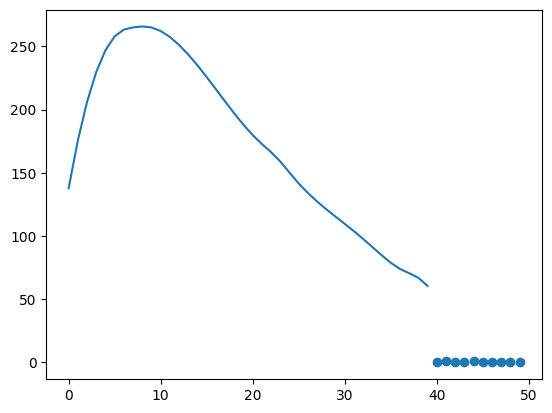

In [54]:
plt.plot(RNN_X[test])
plt.scatter(range(40,50), RNN_Y[test])

In [145]:
def RNN_fitting_wrong(lcs, y, n_pred):
    y_types = np.unique(y)
    y_map = list(range(len(y_types)))
    mapping_dict = {value: y_map[index] for index, value in enumerate(y_types)}
    y_adj = [mapping_dict[value] for value in y]
    n_class = len(y_types)
    print(n_class)
    y_cat = keras.utils.to_categorical(y_adj)
    
    
    (X_train, X_valid, X_test), (y_train, y_valid, y_test) = split_samples(lcs, y_cat, [0.8, 0.1, 0.1], random_state=0)
    
    print(np.shape(lcs[0]))
    model = keras.Sequential([
    layers.Input(np.shape(lcs[0])),
    layers.GRU(32, return_sequences=True),
    layers.GRU(16, return_sequences=True),
    layers.GRU(16),
    layers.Dense(n_class, activation='softmax')
    ])

    model.summary()

    model.compile(
        # Optimizer
        optimizer=keras.optimizers.Adam(learning_rate=1e-2),
        # Loss function to minimize
        loss=keras.losses.CategoricalCrossentropy(),
        # List of metrics to monitor
        metrics=[keras.metrics.CategoricalAccuracy()],
    )

    callbacks = [
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.1,
            patience=5,
            verbose=1,
            min_delta=1e-4,
        ),
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            min_delta=1e-4,
            patience=10,
            verbose=1,
        )
    ]

    history = model.fit(X_train,
        y_train,
        batch_size=32,
        epochs=100,
        validation_data=(X_valid, y_valid),
        callbacks=callbacks
    )

    pred_proba = model.predict(X_test)
    pred_class = np.argmax(pred_proba, axis=1)

    fig = plt.figure(figsize=(17,4))
    ax = plt.subplot(1,3,1)
    ConfusionMatrixDisplay.from_predictions(np.argmax(y_test, axis=1), pred_class, cmap='Blues', ax=ax, xticks_rotation=45)
    plt.title('counts')
    ax = plt.subplot(1,3,2)
    ConfusionMatrixDisplay.from_predictions(np.argmax(y_test, axis=1), pred_class, cmap='Blues', ax=ax, normalize='true', values_format='.3f',  xticks_rotation=45)
    plt.title('normalized by true label')
    ax = plt.subplot(1,3,3)
    ConfusionMatrixDisplay.from_predictions(np.argmax(y_test, axis=1), pred_class, cmap='Blues', ax=ax, normalize='pred', values_format='.3f', xticks_rotation=45)
    plt.title('normalized by prediction')
    plt.show()
    return(plt.show)